# Faster R-CNN Model on KITTI Dataset

### Check Dimension of Images

We will be checking the dimension of the training images,. For training with Faster R-CNN model using PyTorch, all the input images should be of same dimesnion. So we will be calculating dimesnions of all images and resize every image to the most frequent occuring image size, which will be the `target_size`.

In [106]:
# Get dimension of input image
# And resize to most common dimension
import os
import cv2
from collections import Counter

image_dir = "data_object_image_2/training/image_2/"


def get_image_dimensions(image_dir):
    dimensions = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            dimensions.append((h, w))
    return dimensions

dimensions = get_image_dimensions(image_dir)
dim_counter = Counter(dimensions)

In [107]:
# Printing the dimensions found
dimensions_found = ', '.join(f'({dim[0]},{dim[1]})' for dim in dim_counter.keys())
print(f"Dimensions of the images found : {{{dimensions_found}}}\n")

# Printing the count of images for each dimension
for dim, count in dim_counter.items():
    print(f"Dimension {dim} : {count} images")

# Prinitng most common dimensions of the input image
most_common_dim = dim_counter.most_common(1)[0][0]
print(f"\nMost common dimension: {most_common_dim}")

# Set common_dim as the target_size for input images
target_size = most_common_dim

Dimensions of the images found : {(370,1224), (375,1242), (374,1238), (376,1241)}

Dimension (370, 1224) : 770 images
Dimension (375, 1242) : 6057 images
Dimension (374, 1238) : 358 images
Dimension (376, 1241) : 296 images

Most common dimension: (375, 1242)


From above, we can see that the most common image size is `target_size=(375, 1242)`. So we will be resizing all images to this size.

When performing the training procedure, encountered `Out of Memory` issue and the code was crashing due to RAM run out of memory. After investigating, it can be found that this is due to large size of training images (5.79 GB!). So, the training images were compressed by changing the file type from `.png` to `.jpg` and adjust the quality to 85. Thus, for running on the current machine, the quality of the training sample was compromised. Below code compresses the original training image and this file will be used in all the upcomong works.

**Note: The original images are compressed and available in the GitHub. If you want orginal dataset, visit [KITTI Dataset for Object Detection](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d)**

If you have the original `.png` images from the official website, uncomment and use the below code for compressing it.

In [3]:
# Compress training images

# from PIL import Image
# import os

# input_folder = 'data_object_image_2/training/image_2'
# output_folder = 'data_object_image_2/training/compressed_images'

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# for filename in os.listdir(input_folder):
#     if filename.endswith(".png"):
#         img_path = os.path.join(input_folder, filename)
#         img = Image.open(img_path)
        
#         # Compress image by reducing the quality
#         output_path = os.path.join(output_folder, filename.replace('.png', '.jpg'))
#         img.save(output_path, "JPEG", quality=85) # Adjust value of quality

# Faster R-CNN Model from TensorFlow

### Conver KITTI annotations to coco form and load the dataset

Resize the images to the most common dimension of `target_size = (375, 1242)` with more than 6057 instances. We need to resize the corresponding bounding boxes to fit the new image size.

### Split the dataset into Train and Validation

- Clear the directories if there are any files.
- Split training instances into train and val in 80-20 ratio.
- Copy these splits of images and corresponding labels to appropriate directories.

In [7]:
import os
import shutil
import random

def clear_directory(directory):
    """Remove all files and subdirectories in the given directory."""
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# Paths to training images and labels
image_dir = "data_object_image_2/training/compressed_images"
label_dir = "data_object_label_2/training/label_2"

# Output paths for the split dataset
train_images = "datasets/train/images"
val_images = "datasets/val/images"
train_labels = "datasets/train/labels"
val_labels = "datasets/val/labels"

# Clear existing files in target directories
def clear_and_prepare_dir(directories):
    """Clear and prepare the specified directories."""
    for directory in directories:
        if os.listdir(directory):
            print(f"Clearing existing files in {directory}...")
            clear_directory(directory)
            print(f"Directory {directory} has been cleared!")
        os.makedirs(directory, exist_ok=True)

clear_and_prepare_dir([train_images, val_images, train_labels, val_labels])

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Split the dataset (80% train, 20% validation)
split_ratio = 0.8
train_size = int(split_ratio * len(image_files))
train_files = image_files[:train_size]
val_files = image_files[train_size:]

# Copy files to respective directories
for file_name in train_files:
    base_name = os.path.splitext(file_name)[0]
    shutil.copy(os.path.join(image_dir, file_name), os.path.join(train_images, file_name))
    shutil.copy(os.path.join(label_dir, base_name + ".txt"), os.path.join(train_labels, base_name + ".txt"))

for file_name in val_files:
    base_name = os.path.splitext(file_name)[0]
    shutil.copy(os.path.join(image_dir, file_name), os.path.join(val_images, file_name))
    shutil.copy(os.path.join(label_dir, base_name + ".txt"), os.path.join(val_labels, base_name + ".txt"))

print("Dataset has been split and copied!")

Clearing existing files in datasets/train/images...
Directory datasets/train/images has been cleared!
Dataset has been split and copied!


#### Load the train and val dataset 

Load the splitted training and validation dataset with their corresponding coco labels as PyTorch tensors which is suitable for training using the Faster R-CNN model of PyTorch.
- Convert KITTI annoation files to COCO annotations.
- Resize images to the common dimension (`target_size`) and adjust the bounding boxes of these images accordingly.
- Converting images and labels as tensors for training using the model.

In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import torchvision.transforms as T
from PIL import Image

# Class mapping from KITTI dataset to COCO format
CATEGORY_MAPPING = {"Car": 1, "Pedestrian": 2, "Cyclist": 3, "Van": 4,
                    "Truck": 5, "Person_sitting": 6, "Tram": 7, "Misc": 8}

TARGET_SIZE = (375, 1242)  # Common dimension for all images

# Define a transform to convert PIL images to PyTorch tensors
transform = T.Compose([
    T.ToTensor(), 
])

# Function to parse KITTI annotation line and convert to COCO format
def parse_kitti_annotation(line):
    parts = line.strip().split()
    category = parts[0]

    # Skip "Don't Care" labels
    if category == "DontCare":
        return None
    
    if category not in CATEGORY_MAPPING:
        return None
    
    bbox = list(map(float, parts[4:8]))
    x_min, y_min, x_max, y_max = bbox
    return {
        "category": category,
        "bbox": [x_min, y_min, x_max, y_max],
    }

# Function to resize image and adjust bounding boxes accordingly
def resize_image_and_boxes(image, bboxes, target_size):
    orig_height, orig_width = image.shape[:2]

    # Image resize
    image_resized = cv2.resize(image, (target_size[1], target_size[0]))  # Resize (width, height)
    
    scale_x = target_size[1] / orig_width
    scale_y = target_size[0] / orig_height

    # Bounding box resize
    bboxes_resized = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox["bbox"]
        new_bbox = [x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]
        bboxes_resized.append({
            "category": bbox["category"],
            "bbox": new_bbox
        })

    return image_resized, bboxes_resized

# Custom Dataset Class
class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]

        # Load the corresponding annotation file
        label_file = image_file.replace(".jpg", ".txt")
        label_path = os.path.join(self.label_dir, label_file)

        image_path = os.path.join(self.image_dir, image_file)
        image = cv2.imread(image_path)
        
        with open(label_path, "r") as f:
            bboxes = []
            for line in f:
                annotation = parse_kitti_annotation(line)
                if annotation:
                    bboxes.append(annotation)

        # Resize image and update bounding boxes
        image_resized, bboxes_resized = resize_image_and_boxes(image, bboxes, TARGET_SIZE)

        # Convert image to PIL format for PyTorch
        image_pil = Image.fromarray(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

        # Apply the transform to convert PIL image to PyTorch tensor
        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            image_tensor = image_pil

        # Convert bounding boxes and labels to tensors
        boxes = []
        labels = []
        for bbox in bboxes_resized:
            boxes.append(bbox["bbox"])
            labels.append(CATEGORY_MAPPING[bbox["category"]])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create target dictionary for Faster R-CNN
        target = {
            "boxes": boxes,
            "labels": labels,
        }

        return image_tensor, target

# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Initialize datasets
train_dataset = KITTIDataset(train_images, train_labels, transform=transform)
val_dataset = KITTIDataset(val_images, val_labels, transform=transform)

# Create data loaders (considering low memory condition)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

# Iterate over just one batch from the DataLoader
images, targets = next(iter(train_loader))

print(f"Number of Training Samples: {len(train_dataset)}")
print(f"Number of Validation Samples: {len(val_dataset)}")
print(f"Batch size: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Target boxes: {targets[0]['boxes']}")
print(f"Target labels: {targets[0]['labels']}")

Number of Training Samples: 5984
Number of Validation Samples: 1497
Batch size: 4
Image shape: torch.Size([3, 375, 1242])
Target boxes: tensor([[692.5400, 175.2800, 700.8500, 200.6900],
        [100.1400, 171.6500, 210.4700, 216.9300],
        [206.4500, 179.7600, 249.0700, 209.0300],
        [265.5500, 181.2900, 333.7200, 216.7300],
        [213.7900, 183.2700, 296.8000, 216.4400],
        [377.0300, 176.6400, 422.1600, 201.8800],
        [346.2400, 176.6600, 391.1700, 201.6100],
        [452.0100, 176.4000, 479.8100, 193.2000]])
Target labels: tensor([2, 4, 8, 1, 1, 1, 1, 1])


### Visualize some random images with labels

Visualize some of the training images, with their bounding boxes and corresponding label class to verify the data.

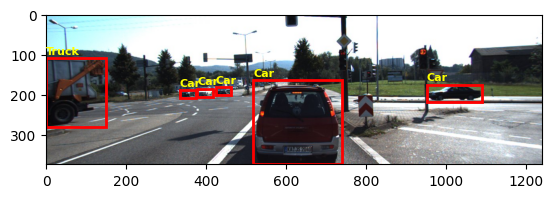

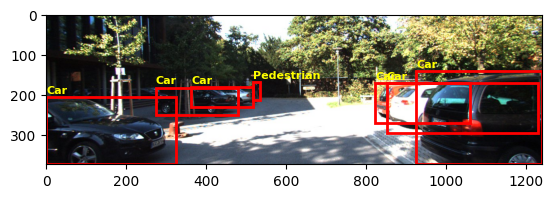

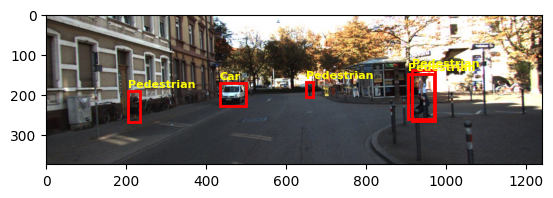

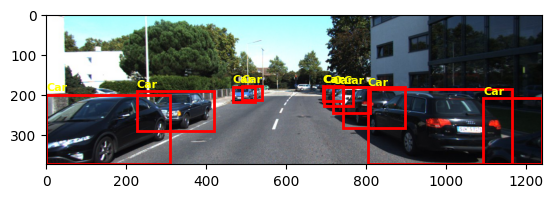

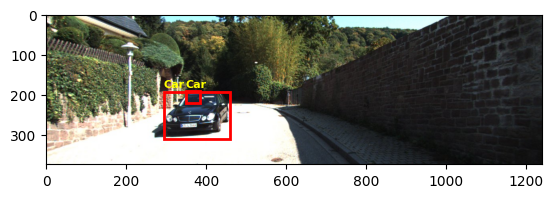

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Function to visualize an image with bounding boxes and labels
def visualize_sample(image, target, category_mapping):
    fig, ax = plt.subplots(1)

    # Convert image tensor to NumPy array and change dimensions
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    # Normalize images
    if image_np.max() > 1.0:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)

    # Iterate over all bounding boxes and labels in the target
    for bbox, label in zip(target['boxes'], target['labels']):
        x_min, y_min, x_max, y_max = bbox

        # Create a Rectangle patch
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the label text
        label_name = list(category_mapping.keys())[list(category_mapping.values()).index(label.item())]
        plt.text(x_min, y_min - 10, label_name, color='yellow', fontsize=8, 
                 fontweight='bold')

    plt.show()

# Visualize random samples from the dataset
for i in range(5):  # 5 random images
    image, target = random.choice(train_dataset)
    visualize_sample(image, target, CATEGORY_MAPPING)


**We Use the Same datasets for both Faster R-CNN and YOLO.v8 so that we can compare their performances. We use `train_images`, `train_labels`, `val_images` and `val_labels` as the datasets.**

### Train the Faster R-CNN Model from Torchvision

### Define the Model

In [15]:
# Define the Faster R-CNN model (which is suitable for larger dataset)

# Import necessary libraries
import torchvision
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import numpy as np
import time
import gc
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the Faster R-CNN model with pretrained COCO weights
model = fasterrcnn_resnet50_fpn(weights="COCO_V1")

# User number of classes customised for KITTI dataset
num_classes = len(CATEGORY_MAPPING) + 1  # 8 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
learning_rate = 0.001  # Reduced learning rate
batch_size = 4  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler - ReduceLROnPlateau can be useful for early stopping
# Wait for 2 epochs and if no improvement in validation loss, reduce the learning rate by a factor of 0.1
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

### Train the model

In [17]:
# Alternative approach for higher dataset

# Directory to save model checkpoints
checkpoint_dir = 'faster-rcnn-checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop with early stopping, learning rate scheduling, and time measurement
# Early stopping parameters
# Stop before overfitting
patience = 4  # Number of epochs to wait for improvement
min_mAP_score = 0  # Initialize the minimum mAP score for early stopping
epochs_no_improve = 0

num_epochs = 4
accumulation_steps = 2  # Number of batches to accumulate gradients

best_model_wts = None

# Initialize metrics
metric = MeanAveragePrecision()

for epoch in range(num_epochs):

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    train_loss = 0
    
    # Start timing for the training phase
    start_time = time.time()
    
    for i, (images, targets) in enumerate(train_loader):

         # Move images and targets to the device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Normalize loss to account for accumulation steps
        losses = losses / accumulation_steps

        # Backward pass
        losses.backward()

        # Gradient accumulation step
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += losses.item() * accumulation_steps

        # Clear RAM memory (for eradicating out of memory issues)
        del images
        del targets
        gc.collect()

        # Print batch-level progress
        if (i + 1) % 100 == 0:
            print(f"Batch {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}")

    # Calculate and print epoch-level training loss
    train_loss /= len(train_loader)
    
    # End timing for the training phase
    epoch_training_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Time: {epoch_training_time:.2f} seconds")

    # Validation loop with inference time measurement
    model.eval()
    val_loss = 0
    metric.reset() # Reset metrics before starting evaluation
    # Start timing for the inference phase
    start_time = time.time()

    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            prediction = model(images)

            # Update metrics
            metric.update(preds=prediction, target=targets)

            # Clear RAM memory
            del images
            del targets
            gc.collect()

    # Calculate and print validation metrics
    inference_time = time.time() - start_time
    mAP_score = metric.compute()
    print(f"Epoch {epoch+1}/{num_epochs}, mAP: {mAP_score['map']:.4f}, Precision: {mAP_score['map_50']:.4f}, Recall: {mAP_score['mar_10']:.4f}, Inference Time: {inference_time:.2f} seconds")

    # Check for improvement and update epochs_no_improve based on mAP score
    if mAP_score['map'] > min_mAP_score:
        min_mAP_score = mAP_score['map']
        epochs_no_improve = 0
        # Save the best model
        best_model_wts = model.state_dict().copy() 
        # Save the model checkpoint
        torch.save(best_model_wts, os.path.join(checkpoint_dir, 'best_model_weights.pth'))
        print("Best model weights saved.")
    else:
        epochs_no_improve += 1

    # Step the learning rate scheduler based on mAP score
    scheduler.step(mAP_score['map'])

    # Early stopping
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Load the best model weights after training
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Loaded the best model weights!")

Epoch [1/8]
Batch 100/1496, Loss: 0.4116
Batch 200/1496, Loss: 0.3664
Batch 300/1496, Loss: 0.3389
Batch 400/1496, Loss: 0.6457
Batch 500/1496, Loss: 0.3407
Batch 600/1496, Loss: 0.3654
Batch 700/1496, Loss: 0.4405
Batch 800/1496, Loss: 0.2610
Batch 900/1496, Loss: 0.4907
Batch 1000/1496, Loss: 0.2509
Batch 1100/1496, Loss: 0.3977
Batch 1200/1496, Loss: 0.1317
Batch 1300/1496, Loss: 0.2226
Batch 1400/1496, Loss: 0.3150
Epoch 1/8, Training Loss: 0.7261, Training Time: 33290.64 seconds
Epoch 1/8, mAP: 0.1463, Precision: 0.3077, Recall: 0.3070, Inference Time: 3406.97 seconds
Best model weights saved.
Epoch [2/8]
Batch 100/1496, Loss: 0.2010
Batch 200/1496, Loss: 0.2688
Batch 300/1496, Loss: 0.2256
Batch 400/1496, Loss: 0.3157
Batch 500/1496, Loss: 0.1311
Batch 600/1496, Loss: 0.2220
Batch 700/1496, Loss: 0.1808
Batch 800/1496, Loss: 0.1179
Batch 900/1496, Loss: 0.3408
Batch 1000/1496, Loss: 0.3876
Batch 1100/1496, Loss: 0.2882
Batch 1200/1496, Loss: 0.2337
Batch 1300/1496, Loss: 0.2102
B

KeyboardInterrupt: 

Stopped after 4 epochs due to insufficient machine compactability and excess training time. Got a trained model after 4 epochs and will use this model for comparision with YOLOv8 model, which is trained for 4 epochs.

We also computes some tests on the validation dataset and check whether they are good for predictions. These tests include calculating some of the basic metrices like mAP, Precision, Recall, and Loss. We will also calculate the Average Inference Time taken by the model.

### Evaluation Metrices

We haven't stored the metrices values, just printed, and the training and evaluation took almost 2 days (40.98 hours!) to complete. It is difficult to redo the training process. Hence manually inputting the metrices from the training output for visualization.

Time taken for training the KITTI dataset by Faster R-CNN model.

In [29]:
# Manually input the recorded values for each epoch
import pandas as pd

data = {
    'Epoch': [1, 2, 3, 4],
    'Training Loss': [0.7261, 0.5199, 0.4498, 0.4118],
    'mAP': [0.1463, 0.2574, 0.3050, 0.3341],
    'Precision': [0.3077, 0.4882, 0.5667, 0.6160],
    'Recall': [0.3070, 0.4196, 0.4627, 0.4684],
    'Training Time (s)': [33290.64, 33207.58, 33409.82, 33670.88],
    'Inference Time (s)': [3406.97, 3428.70, 3450.52, 3695.79]
}

# Create the DataFrame
df = pd.DataFrame(data)

   Epoch  Training Loss     mAP  Precision  Recall  Training Time (s)  \
0      1         0.7261  0.1463     0.3077  0.3070           33290.64   
1      2         0.5199  0.2574     0.4882  0.4196           33207.58   
2      3         0.4498  0.3050     0.5667  0.4627           33409.82   
3      4         0.4118  0.3341     0.6160  0.4684           33670.88   

   Inference Time (s)  
0             3406.97  
1             3428.70  
2             3450.52  
3             3695.79  


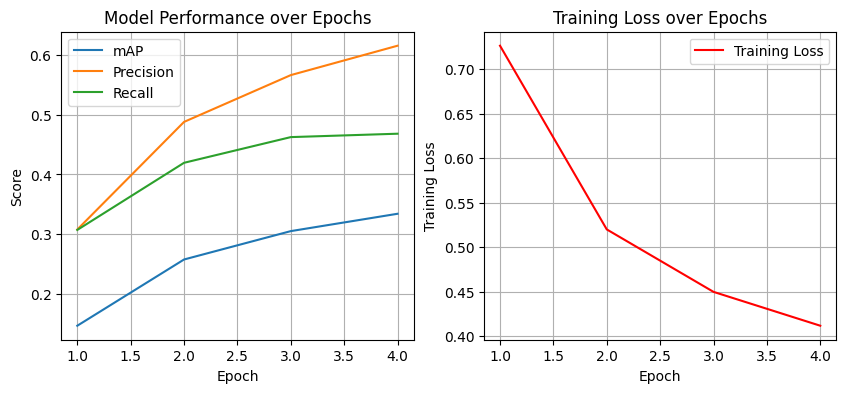

In [104]:
# Plot the metrices
import matplotlib.pyplot as plt

# Plot mAP, Precision, and Recall
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['mAP'], label='mAP')
plt.plot(df['Epoch'], df['Precision'], label='Precision')
plt.plot(df['Epoch'], df['Recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Model Performance over Epochs')
plt.legend()
plt.grid(True)

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


We can see that the mean average precision, the precision and recall of Faster R-CNN model increases when number of epoch increases and the loss is decreasing accordingly.

### Load the Model for Evaluation

Since we have saved the model, we don't want to train the model again with the same dataset. We can use the pretained weights for further analysis.

In [24]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the Faster R-CNN model architecture
model = fasterrcnn_resnet50_fpn(weights=None)  # Initialize without pretrained weights

# Replace the classifier with the one that matches the number of classes in your dataset
num_classes = len(CATEGORY_MAPPING) + 1  # 8 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model_load_path = "faster-rcnn-checkpoints/best_model_weights.pth"
model.load_state_dict(torch.load(model_load_path))

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(f"Model loaded from {model_load_path}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Bhagavath Kumar/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:30<00:00, 3.31MB/s]


Model loaded from faster-rcnn-checkpoints/best_model_weights.pth


### Prediction and Visualization

In [60]:
# Load the trained model weights
model.load_state_dict(torch.load('best_model_weights.pth'))
model.eval()  # Set the model to evaluation mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Visualize some test images to check whether the objects are detected correctly. We set a lower confidence threshold of 0.8, so that only images with a threshold value of 0.8 will be plotted.

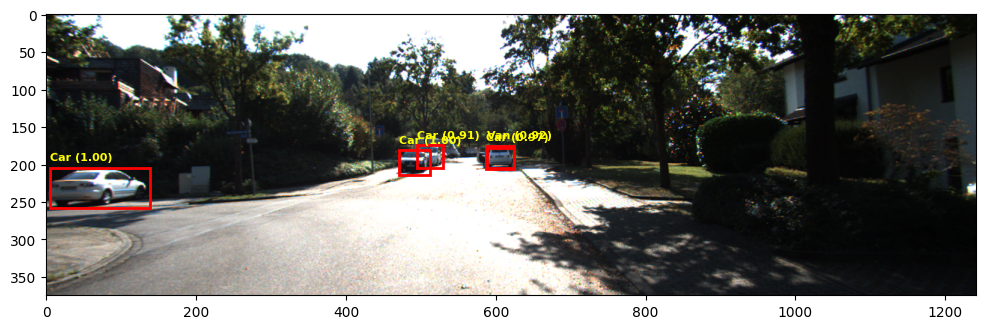

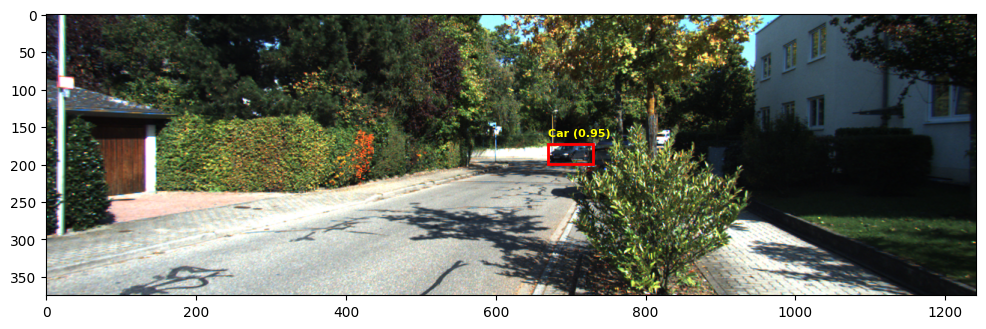

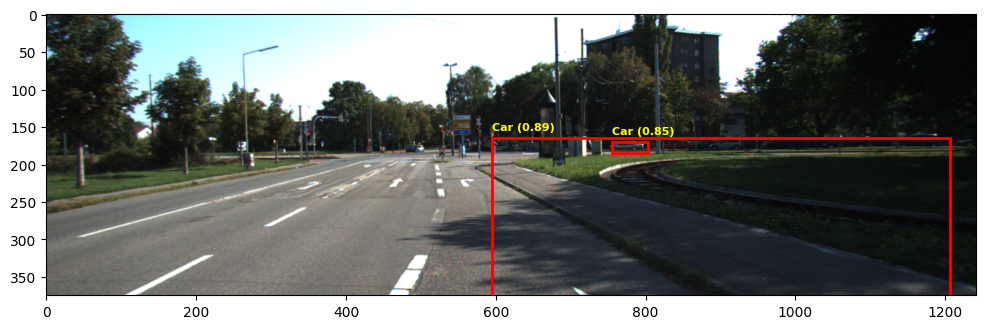

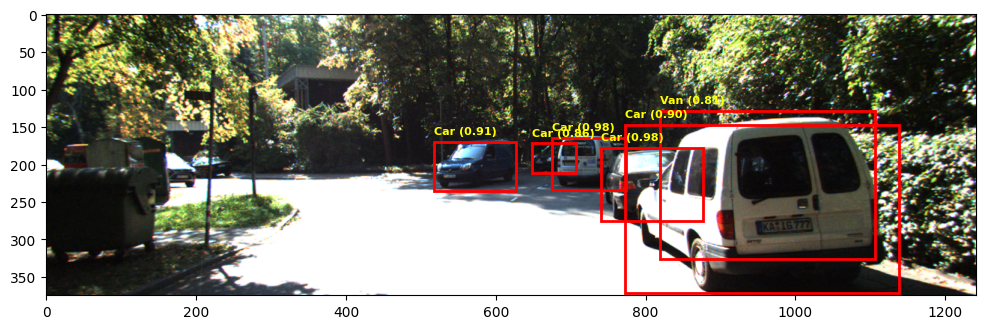

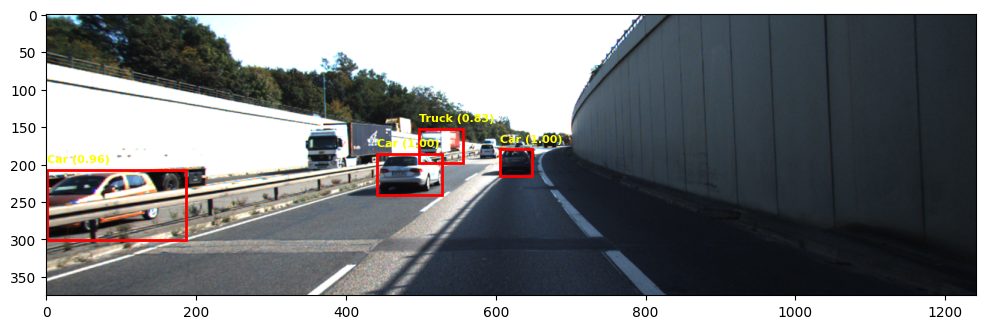

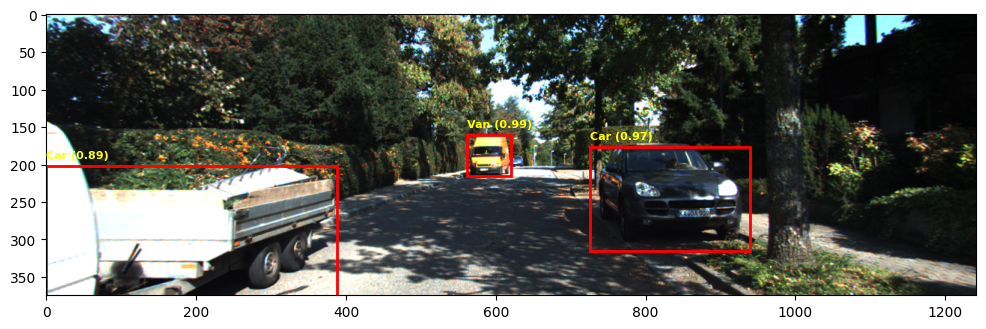

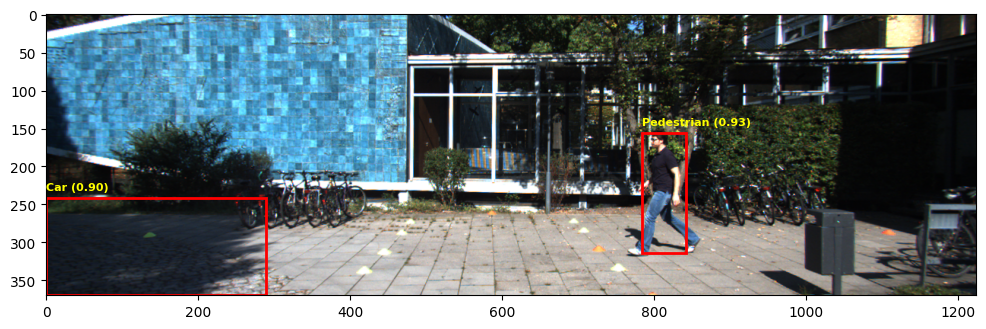

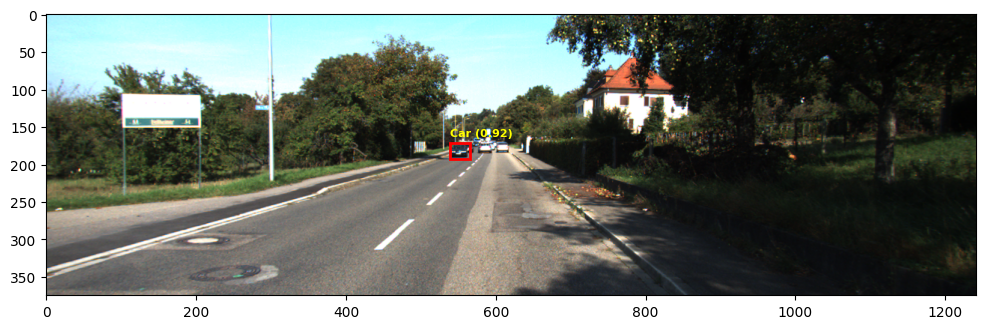

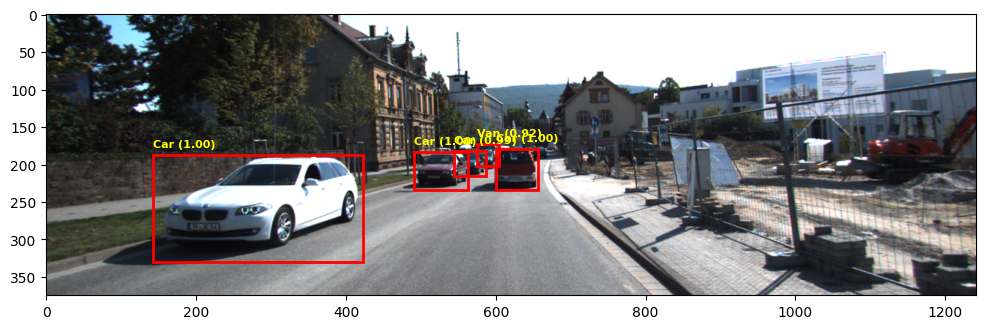

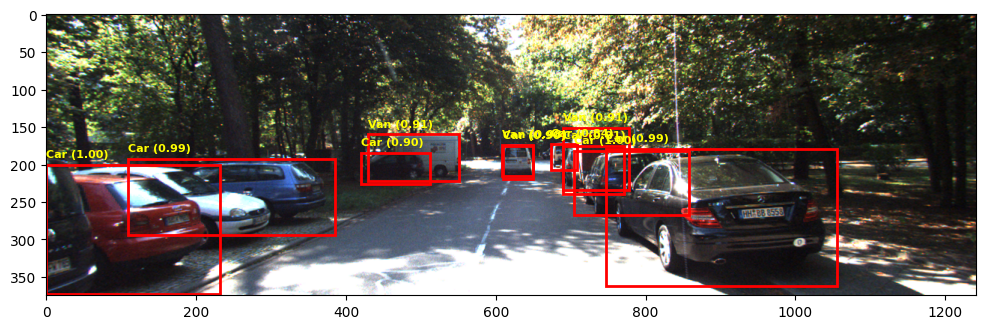

In [114]:
import torch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

CATEGORY_MAPPING = {"Car": 1, "Pedestrian": 2, "Cyclist": 3, "Van": 4,
                    "Truck": 5, "Person_sitting": 6, "Tram": 7, "Misc": 8}

# Visualize the predictions
def visualize_predictions(image, predictions, category_mapping):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Get predictions
    pred_boxes = predictions[0]['boxes']
    pred_labels = predictions[0]['labels']
    pred_scores = predictions[0]['scores']

    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > 0.8:  # Filter out low confidence predictions
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            # Bounding box
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Label text
            label_name = list(category_mapping.keys())[list(category_mapping.values()).index(label.item())]
            plt.text(x_min, y_min - 10, f'{label_name} ({score:.2f})', color='yellow', fontsize=8, fontweight='bold')

    plt.show()

# Predict and visualize
image_dir = 'datasets/test/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
sample_images = random.sample(image_files, 10)  # Randomly select 10 images

for image_file in sample_images:
    image_path = os.path.join(image_dir, image_file)
    
    # Open and prepare image
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        predictions = model(image_tensor)

    # Visualize results
    visualize_predictions(image, predictions, CATEGORY_MAPPING)


### Predicting Video Input

Faster R-CNN model is also capable of predicting video inputs. But it will take a lot of time to process the image, which makes it not suitable for real time applications

In [123]:
import cv2
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the video capture object
video_path = 'road-video-dubai.mp4'  # video path
cap = cv2.VideoCapture(video_path)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Class labels
class_names = ["background"] + list(CATEGORY_MAPPING.keys())

# Define output video writer
output_path = 'faster_rcnn_video1.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

# Function to draw predictions on frames
def draw_predictions(frame, predictions):
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score > 0.8:  # Filter predictions by score
            xmin, ymin, xmax, ymax = map(int, box)
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
            label_text = f"{class_names[label]}: {score:.2f}"
            cv2.putText(frame, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    return frame

start_time = time.time()

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a PIL image and apply the transformation
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(image)[0]

    # Draw predictions on the frame
    frame = draw_predictions(frame, predictions)

    # Write the frame into the output video
    out.write(frame)

end_time = time.time()

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

print(f'Video file {video_path} saved to directory as {output_path}')

Video file road-video-dubai.mp4 saved to directory as faster_rcnn_video1.mp4


In [131]:
inference_time = end_time - start_time
print(f'Faster R-CNN took {inference_time:.2f} seconds to predict the video file {video_path}')

Faster R-CNN took 3715.93 seconds to predict the video file road-video-dubai.mp4


The output video is saved to the working directory.

A comparison between Faster R-CNN and YOLOv8 models are made in the file `model_comparison.ipynb`.